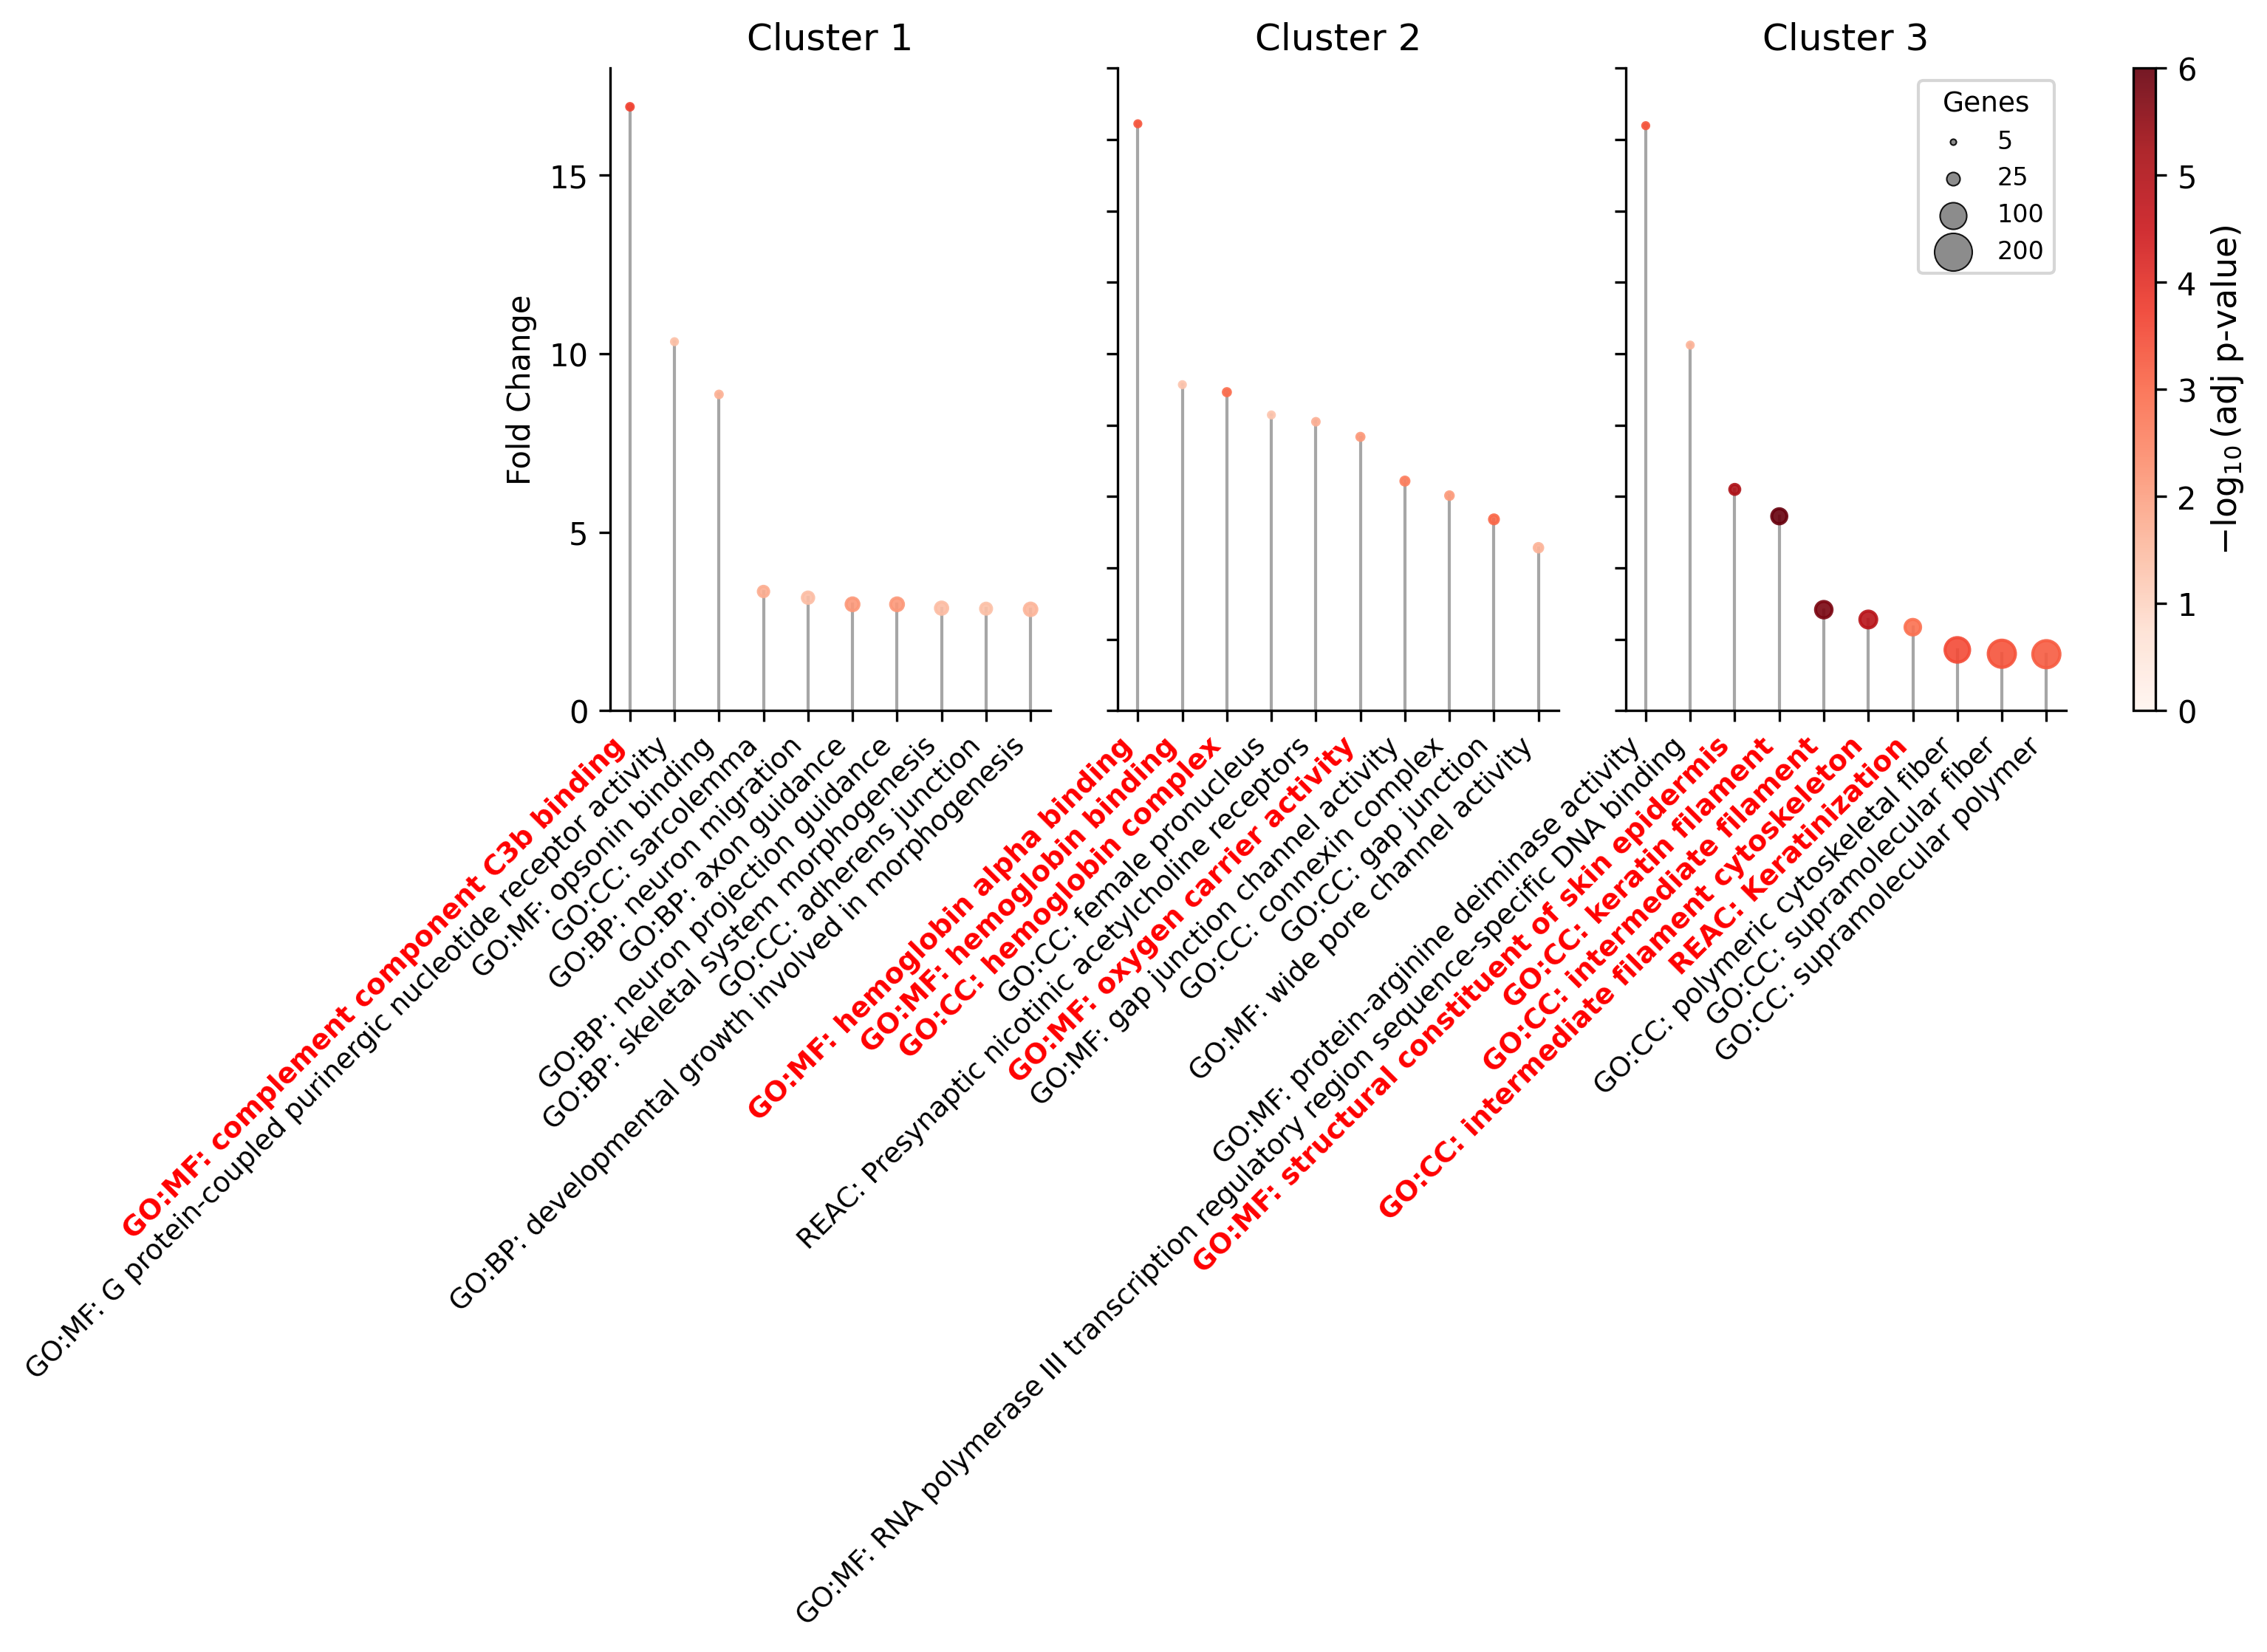

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import matplotlib.gridspec as gridspec

files = [
    ("../../Supplementary_Tables/ST4/rMDS_cluster1_GO.csv", "Cluster 1"),
    ("../../Supplementary_Tables/ST4/rMDS_cluster2_GO.csv", "Cluster 2"),
    ("../../Supplementary_Tables/ST4/rMDS_cluster3_GO.csv", "Cluster 3"),
]

fig = plt.figure(figsize=(9, 5), dpi=300)
gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[1, 1, 1, 0.05], wspace=0.2)

axes = [fig.add_subplot(gs[0, i]) for i in range(3)]
cax = fig.add_subplot(gs[0, 3])

cmap = mpl.colormaps["Reds"]  # Updated to avoid deprecation warning
norm = mpl.colors.Normalize(vmin=0, vmax=6)

example_sizes = [5, 25, 100, 200]
example_markers = [plt.scatter([], [], s=size*0.75, edgecolors='black',
                               facecolors='gray', alpha=0.9, linewidths=0.5)
                   for size in example_sizes]
labels = [f"{s}" for s in example_sizes]

# Replace with actual terms you want to highlight
highlight_terms = {
    "GO:MF: complement component C3b binding",
    "GO:MF: hemoglobin alpha binding",
    "GO:MF: hemoglobin binding",
    "GO:MF: oxygen carrier activity",
    "GO:CC: keratin filament",
    "GO:CC: hemoglobin complex",
    "GO:CC: intermediate filament",
    "GO:CC: intermediate filament cytoskeleton",
    "REAC: Keratinization",
    "GO:MF: structural constituent of skin epidermis"
}
last_scatter = None

for ax, (file, title) in zip(axes, files):
    df = pd.read_csv(file, sep=",")
    df['combined_name'] = df['source'].astype(str) + ": " + df['term_name'].astype(str)
    df['fold_enrichment'] = (
        (df['intersection_size'] / df['query_size']) /
        (df['term_size'] / df['effective_domain_size'])
    )
    df['composite_score'] = df['fold_enrichment'].rank(ascending=True)
    df.sort_values("composite_score", ascending=False, inplace=True)
    df_top20 = df[df['combined_name'].str.startswith(('G', 'R'))].head(10).reset_index(drop=True)

    x_positions = np.arange(len(df_top20))

    for idx, row in df_top20.iterrows():
        ax.plot([idx, idx], [0, row['fold_enrichment']],
                color='gray', linewidth=1, alpha=0.7, zorder=1)

    scatter = ax.scatter(
        x_positions,
        df_top20['fold_enrichment'],
        s=df_top20['intersection_size']*0.75,
        c=df_top20['negative_log10_of_adjusted_p_value'],
        cmap=cmap,
        norm=norm,
        linewidths=1,
        alpha=0.9,
        zorder=2
    )

    ax.set_xticks(x_positions)
    ax.set_xticklabels(df_top20['combined_name'], fontsize=9, rotation=45, ha='right')

    # Highlight selected terms
    for tick_label in ax.get_xticklabels():
        if tick_label.get_text() in highlight_terms:
            tick_label.set_fontweight("bold")
            tick_label.set_color("red")

    ax.set_title(title, fontsize=12)
    ax.set_ylim([0, 18])
    ax.set_yticklabels([])
    ax.grid(False)
    sns.despine(ax=ax)
    last_scatter = scatter

axes[0].set_ylabel('Fold Change')
axes[0].set_yticks([0, 5, 10, 15])
axes[0].set_yticklabels([0, 5, 10, 15])

cbar = plt.colorbar(last_scatter, cax=cax)
cbar.set_label(r"$-\log_{10}$(adj p-value)", fontsize=11)

axes[-1].legend(
    example_markers,
    labels,
    title="Genes",
    loc='upper right',
    frameon=True,
    fontsize=8,
    title_fontsize=9
)

plt.subplots_adjust(bottom=0.3)
plt.savefig("F3C.pdf", bbox_inches='tight')
plt.show()